# Step-1 : Importing libraries and helper functions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import numpy as np
import random

# Step-2 : Importing the Famous MNIST Handwritten data-set

In [2]:
(x_train,y_train),(x_test,y_test) = load_data()

In [3]:
x_train.shape,x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


# Step-3 : Visualizing Triplets

In [5]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([y_train[i]])
    plt.show()

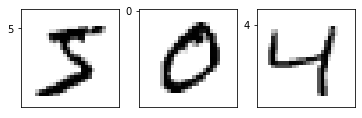

In [6]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

# Step-4 : Creating batch of triplet [Anchor,Positives,Negative]

In [7]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]

        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

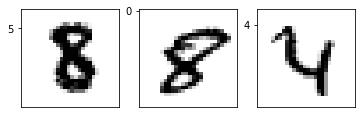

(60000,)


In [8]:
examples = create_batch(1)
plot_triplets(examples)
print(y_train.shape)

# Step-5 : Embedding Model

In [9]:
emb_size = 64

input_img = Input(shape = (784,))
l1 = Dense(64,activation = 'relu')(input_img)
l2 = Dense(emb_size,activation = 'sigmoid')(l1)

embedding_model = Model(input_img,l2)


In [10]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.5470849  0.5581019  0.5303294  0.42897078 0.5008388  0.49896953
 0.5421109  0.5465979  0.5886614  0.50570047 0.48099917 0.53690434
 0.5290624  0.52630883 0.49157286 0.53387743 0.34836528 0.5224821
 0.55013824 0.5786736  0.59940284 0.59983236 0.48334238 0.4528636
 0.55099624 0.51797235 0.5886673  0.40958127 0.53064394 0.534604
 0.4747179  0.6166971  0.5809548  0.58763516 0.49495465 0.55083144
 0.46090746 0.5669902  0.6158796  0.45422807 0.4744705  0.48243368
 0.39773133 0.4625698  0.40386263 0.55074865 0.5680739  0.45313072
 0.49444014 0.5964719  0.3846745  0.4585041  0.46120608 0.48489344
 0.61778104 0.44632605 0.55523056 0.35045922 0.67026937 0.58681566
 0.46421045 0.51758766 0.44203854 0.5393596 ]


# Step-6 : Siamese Network

In [11]:
input_anchor = Input(shape = (784,))
input_positive = Input(shape = (784,))
input_negative = Input(shape = (784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

siamese_network = Model([input_anchor, input_positive, input_negative], output)
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 64)           54400       input_2[0][0]                    
                                                                 input_3[0][0]              

# Step-7 : Triplet Loss

In [12]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

# Step-8 : Training Model

In [13]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y
        
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

siamese_network.compile(loss=triplet_loss, optimizer=Adam())

_ = siamese_network.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=1
    )

  ...
    to  
  ['...']
Train for 29 steps
Epoch 1/10
29/29 [==============================] - 24s 817ms/step - loss: 0.1595
Epoch 2/10
29/29 [==============================] - 21s 736ms/step - loss: 0.0731
Epoch 3/10
29/29 [==============================] - 22s 760ms/step - loss: 0.0544
Epoch 4/10
29/29 [==============================] - 27s 925ms/step - loss: 0.0483
Epoch 5/10
29/29 [==============================] - 24s 813ms/step - loss: 0.0439
Epoch 6/10
29/29 [==============================] - 29s 983ms/step - loss: 0.0406
Epoch 7/10
29/29 [==============================] - 25s 854ms/step - loss: 0.0372
Epoch 8/10
29/29 [==============================] - 24s 816ms/step - loss: 0.0347
Epoch 9/10
29/29 [==============================] - 24s 832ms/step - loss: 0.0327
Epoch 10/10
29/29 [==============================] - 24s 842ms/step - loss: 0.0307
